Running grid: 24 configs × 3 seeds = 72 runs
cfg d=0.5, s=0.1, wd=0.0005, h=64, ew=uniform -> mean test 0.8073 ± 0.0058
cfg d=0.5, s=0.1, wd=0.0005, h=64, ew=cosine_similarity -> mean test 0.7490 ± 0.0050
cfg d=0.5, s=0.1, wd=0.005, h=64, ew=uniform -> mean test 0.8207 ± 0.0034
cfg d=0.5, s=0.1, wd=0.005, h=64, ew=cosine_similarity -> mean test 0.7563 ± 0.0069
cfg d=0.5, s=0.2, wd=0.0005, h=64, ew=uniform -> mean test 0.8107 ± 0.0021
cfg d=0.5, s=0.2, wd=0.0005, h=64, ew=cosine_similarity -> mean test 0.7540 ± 0.0022
cfg d=0.5, s=0.2, wd=0.005, h=64, ew=uniform -> mean test 0.8200 ± 0.0024
cfg d=0.5, s=0.2, wd=0.005, h=64, ew=cosine_similarity -> mean test 0.7543 ± 0.0017
cfg d=0.7, s=0.1, wd=0.0005, h=64, ew=uniform -> mean test 0.8147 ± 0.0062
cfg d=0.7, s=0.1, wd=0.0005, h=64, ew=cosine_similarity -> mean test 0.7527 ± 0.0060
cfg d=0.7, s=0.1, wd=0.005, h=64, ew=uniform -> mean test 0.8193 ± 0.0012
cfg d=0.7, s=0.1, wd=0.005, h=64, ew=cosine_similarity -> mean test 0.7507 ± 0.0042
c

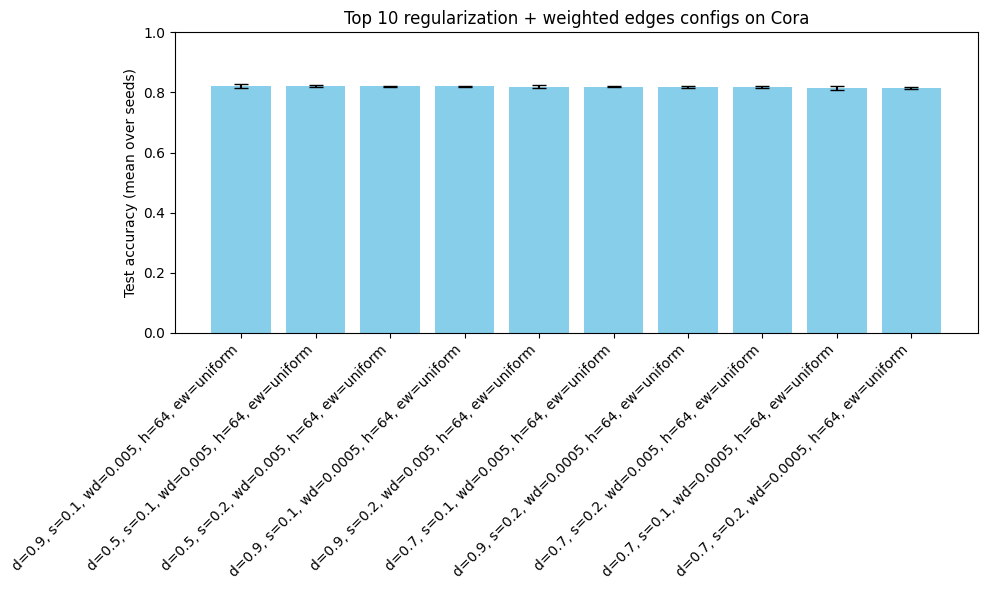

Saved plot to weighted_edges_top10.png


In [2]:
# weighted_edges.py
import os, random, time, csv, itertools
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected

# ----------------------------
# Model: simple 2-layer GCN
# ----------------------------
class GCN(nn.Module):
    def __init__(self, in_ch, hid_ch, out_ch, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hid_ch, normalize=True)
        self.conv2 = GCNConv(hid_ch, out_ch, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x  # raw logits

# ----------------------------
# Utilities
# ----------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def get_weighted_edges(data, method="cosine_similarity"):
    """
    Generates edge weights based on a given method.
    """
    if method == "cosine_similarity":
        row, col = data.edge_index
        # Normalize features to compute cosine similarity
        norm_x = F.normalize(data.x, p=2, dim=1)
        edge_weights = (norm_x[row] * norm_x[col]).sum(dim=1)
        # Ensure positive weights
        edge_weights = F.relu(edge_weights)
        return edge_weights
    else: # Default to uniform weights
        return torch.ones(data.edge_index.size(1), device=data.x.device)

# ----------------------------
# Train one run
# ----------------------------
def train_one_run(dataset_name="Cora",
                  hidden=64,
                  dropout=0.5,
                  weight_decay=5e-4,
                  label_smoothing=0.0,
                  edge_weight_method="cosine_similarity",
                  lr=0.01,
                  max_epochs=300,
                  patience=50,
                  seed=0,
                  device=None,
                  verbose=False):

    set_seed(seed)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    dataset = Planetoid(root=os.path.join("data", dataset_name), name=dataset_name)
    data = dataset[0].to(device)

    # Generate edge weights
    edge_weight = get_weighted_edges(data, method=edge_weight_method).to(device)

    model = GCN(dataset.num_node_features, hidden, dataset.num_classes, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    best_val = -1.0
    best_test = 0.0
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, edge_weight)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            out_eval = model(data.x, data.edge_index, edge_weight)
            pred = out_eval.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
            test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

        if val_acc > best_val:
            best_val = val_acc
            best_test = test_acc
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and epoch % 50 == 0:
            print(f"Seed {seed} | epoch {epoch} | loss {loss.item():.4f} | "
                  f"val {val_acc:.4f} | test {test_acc:.4f}")

        if epochs_no_improve >= patience:
            break

    return {"best_val": best_val, "test_at_best": best_test, "best_epoch": best_epoch}

# ----------------------------
# Grid search
# ----------------------------
def run_grid_search(
    seeds=(0,1,2),
    dropout_list=(0.5, 0.7, 0.9),
    label_smooth_list=(0.1, 0.2),
    weight_decay_list=(5e-4, 5e-3),
    hidden_list=(64,),
    edge_weight_methods=("cosine_similarity", "uniform"),
    dataset_name="Cora",
    max_epochs=300,
    patience=50,
    out_csv="weighted_edges_results.csv",
    device=None,
    verbose=False
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    combos = list(itertools.product(dropout_list, label_smooth_list, weight_decay_list, hidden_list, edge_weight_methods))
    print(f"Running grid: {len(combos)} configs × {len(seeds)} seeds = {len(combos)*len(seeds)} runs")

    # CSV header
    header = ["dropout", "label_smoothing", "weight_decay", "hidden", "edge_weight_method",
              "seed", "best_val", "test_at_best", "best_epoch"]
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

    summary = OrderedDict()
    for (dropout, lab_smooth, wd, hid, ew_method) in combos:
        cfg_key = (dropout, lab_smooth, wd, hid, ew_method)
        summary[cfg_key] = []

        for seed in seeds:
            res = train_one_run(
                dataset_name=dataset_name,
                hidden=hid,
                dropout=dropout,
                weight_decay=wd,
                label_smoothing=lab_smooth,
                edge_weight_method=ew_method,
                lr=0.01,
                max_epochs=max_epochs,
                patience=patience,
                seed=seed,
                device=device,
                verbose=verbose
            )
            with open(out_csv, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([dropout, lab_smooth, wd, hid, ew_method, seed,
                                 f"{res['best_val']:.6f}", f"{res['test_at_best']:.6f}",
                                 res["best_epoch"]])
            summary[cfg_key].append(res["test_at_best"])

        arr = np.array(summary[cfg_key])
        mean, std = arr.mean(), arr.std()
        print(f"cfg d={dropout}, s={lab_smooth}, wd={wd}, h={hid}, ew={ew_method} -> mean test {mean:.4f} ± {std:.4f}")

    rows = []
    for k, vals in summary.items():
        dropout, lab_smooth, wd, hid, ew_method = k
        arr = np.array(vals)
        rows.append({
            "dropout": dropout,
            "label_smoothing": lab_smooth,
            "weight_decay": wd,
            "hidden": hid,
            "edge_weight_method": ew_method,
            "mean_test": arr.mean(),
            "std_test": arr.std(),
            "n_runs": len(arr)
        })
    df = pd.DataFrame(rows)
    df = df.sort_values("mean_test", ascending=False).reset_index(drop=True)
    df.to_csv("weighted_edges_summary.csv", index=False)
    print("\nSaved detailed runs to", out_csv)
    print("Saved summary to weighted_edges_summary.csv")
    return df

# ----------------------------
# Plot helper
# ----------------------------
def plot_topk(df, k=10, save_png="weighted_edges_topk.png"):
    topk = df.head(k)
    labels = []
    means = topk["mean_test"].values
    stds = topk["std_test"].values
    for _, row in topk.iterrows():
        labels.append(f"d={row['dropout']}, s={row['label_smoothing']}, "
                      f"wd={row['weight_decay']}, h={int(row['hidden'])}, ew={row['edge_weight_method']}")
    plt.figure(figsize=(10,6))
    x = np.arange(len(labels))
    plt.bar(x, means, yerr=stds, capsize=5, color="skyblue")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0,1)
    plt.ylabel("Test accuracy (mean over seeds)")
    plt.title(f"Top {k} regularization + weighted edges configs on Cora")
    plt.tight_layout()
    plt.savefig(save_png, dpi=200)
    plt.show()
    print("Saved plot to", save_png)

# ----------------------------
# Main entry
# ----------------------------
if __name__ == "__main__":
    seeds = (0, 1, 2)
    dropout_list = (0.5, 0.7, 0.9)
    label_smooth_list = (0.1, 0.2)
    weight_decay_list = (5e-4, 5e-3)
    hidden_list = (64,)
    edge_weight_methods = ("uniform", "cosine_similarity") # Added new parameter here

    df_summary = run_grid_search(
        seeds=seeds,
        dropout_list=dropout_list,
        label_smooth_list=label_smooth_list,
        weight_decay_list=weight_decay_list,
        hidden_list=hidden_list,
        edge_weight_methods=edge_weight_methods,
        dataset_name="Cora",
        max_epochs=300,
        patience=50,
        out_csv="weighted_edges_runs.csv",
        verbose=False,
    )
    
    print("\n=== Top configs (by mean test acc) ===")
    print(df_summary.head(10))
    plot_topk(df_summary, k=10, save_png="weighted_edges_top10.png")